In [22]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [23]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭
nfreq = 1

In [24]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 1 / fcen * 2
monitor_blank = 1 / fcen * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = width_ag + width_sio2 + width_ag
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y, side=mp.Low),
    mp.PML(tpml, direction=mp.Y, side=mp.High)
]

In [25]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [26]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [27]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag]
    )
    for src in sources
]

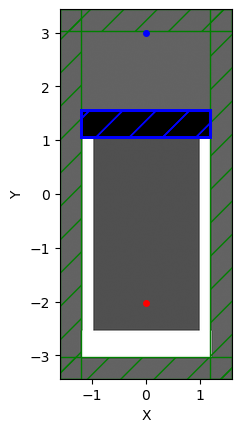

In [28]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(0, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]


def J(fields):
    return npa.sum(npa.real(fields) ** 2) 

opt_list = [
    mpa.OptimizationProblem(
        simulation=sims[i],
        objective_functions=[J],
        objective_arguments=[FourierFields_list[i]],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )
    for i in range(num_sources)
]
for i in range(num_sources):
    opt_list[i].plot2D(True)

In [13]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [14]:
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)


In [ ]:
n = Nx * layer_num
np.random.seed(3)           
x = 0.4 + 0.2 * np.random.rand(n)  

cur_beta = 4

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.abs(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # 평균 FoM 기준 변화율 계산 (💡 여기 수정!)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.005 and change2 < 0.005) and (bin_change1 < 0.003 and bin_change2 < 0.003):
            # beta = beta + np.tanh((beta - 0.5)*0.02)
            beta *= 1.2

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")

    # plt.figure(figsize=(3, 2))
    # ax = plt.gca()
    # opt_list[0].plot2D(
    #     False,
    #     output_plane=mp.Volume(
    #         size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
    #         center=mp.Vector3(0, full_center_y, 0)
    #     ),
    #     ax=ax,
    #     show_sources=False,
    #     show_monitors=False,
    #     show_boundary_layers=False,
    # )
    # ax.axis("off")
    # plt.show()

    return v_new, beta

mp.verbosity(0)
Max_iter = 300

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.98:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        print("FOM increases : ", )
        break


--- Iter 1 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.00047104868731726295]
Mean FoM: 0.000471
Binarization degree: 0.1397

--- Iter 2 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.0021383510280159764]
Mean FoM: 0.002138
Binarization degree: 0.1395

--- Iter 3 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.008201947572317599]
Mean FoM: 0.008202
Binarization degree: 0.1395

--- Iter 4 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.021997879217475834]
Mean FoM: 0.021998
Binarization degree: 0.1409

--- Iter 5 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.046447785306002895]
Mean FoM: 0.046448
Binarization degree: 0.1447

--- Iter 6 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.09567283333521413]
Mean FoM: 0.095673
Binarization degree: 0.1522

--- Iter 7 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.16696091842749117]
Mean FoM: 0.166961
Binarization degree: 0.1587

--- Iter 8 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.06543701134535197]
Mean FoM: 0.065437
Binarization degree: 0.1713

--- Iter 9 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.14706215516794455]
Mean FoM: 0.147062
Binarization degree: 0.1829

--- Iter 10 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.23398775136889077]
Mean FoM: 0.233988
Binarization degree: 0.1972

--- Iter 11 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.2128149238117035]
Mean FoM: 0.212815
Binarization degree: 0.2138

--- Iter 12 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.22577503643357003]
Mean FoM: 0.225775
Binarization degree: 0.2299

--- Iter 13 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.2957631210728078]
Mean FoM: 0.295763
Binarization degree: 0.2449

--- Iter 14 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.3590801077019382]
Mean FoM: 0.359080
Binarization degree: 0.2591

--- Iter 15 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.3643913501187558]
Mean FoM: 0.364391
Binarization degree: 0.2683

--- Iter 16 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.4717752242601808]
Mean FoM: 0.471775
Binarization degree: 0.2737

--- Iter 17 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.3693101959812354]
Mean FoM: 0.369310
Binarization degree: 0.2861

--- Iter 18 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5184387692785384]
Mean FoM: 0.518439
Binarization degree: 0.2971

--- Iter 19 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.2151593200095744]
Mean FoM: 0.215159
Binarization degree: 0.3080

--- Iter 20 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.4058851022061188]
Mean FoM: 0.405885
Binarization degree: 0.3138

--- Iter 21 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.43850519162881363]
Mean FoM: 0.438505
Binarization degree: 0.3185

--- Iter 22 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.3502764848422333]
Mean FoM: 0.350276
Binarization degree: 0.3235

--- Iter 23 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.3560883847045266]
Mean FoM: 0.356088
Binarization degree: 0.3286

--- Iter 24 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.42536293386941776]
Mean FoM: 0.425363
Binarization degree: 0.3356

--- Iter 25 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5209334199240088]
Mean FoM: 0.520933
Binarization degree: 0.3447

--- Iter 26 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.4759924147219851]
Mean FoM: 0.475992
Binarization degree: 0.3541

--- Iter 27 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.40900281986337694]
Mean FoM: 0.409003
Binarization degree: 0.3622

--- Iter 28 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.4662750083065659]
Mean FoM: 0.466275
Binarization degree: 0.3684

--- Iter 29 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5597469076820698]
Mean FoM: 0.559747
Binarization degree: 0.3734

--- Iter 30 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5229954278686942]
Mean FoM: 0.522995
Binarization degree: 0.3788

--- Iter 31 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.4888696015540635]
Mean FoM: 0.488870
Binarization degree: 0.3846

--- Iter 32 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5249967026576506]
Mean FoM: 0.524997
Binarization degree: 0.3900

--- Iter 33 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5834416823683799]
Mean FoM: 0.583442
Binarization degree: 0.3955

--- Iter 34 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5476080490055457]
Mean FoM: 0.547608
Binarization degree: 0.3999

--- Iter 35 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5439654014182442]
Mean FoM: 0.543965
Binarization degree: 0.4023

--- Iter 36 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6005202628815435]
Mean FoM: 0.600520
Binarization degree: 0.4031

--- Iter 37 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.580195375530008]
Mean FoM: 0.580195
Binarization degree: 0.4035

--- Iter 38 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5707084401394771]
Mean FoM: 0.570708
Binarization degree: 0.4050

--- Iter 39 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6090795945293012]
Mean FoM: 0.609080
Binarization degree: 0.4075

--- Iter 40 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6071288768544862]
Mean FoM: 0.607129
Binarization degree: 0.4102

--- Iter 41 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5830137950156218]
Mean FoM: 0.583014
Binarization degree: 0.4123

--- Iter 42 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6159162506298512]
Mean FoM: 0.615916
Binarization degree: 0.4132

--- Iter 43 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6281779925249568]
Mean FoM: 0.628178
Binarization degree: 0.4130

--- Iter 44 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6219737350974569]
Mean FoM: 0.621974
Binarization degree: 0.4126

--- Iter 45 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6490477770171554]
Mean FoM: 0.649048
Binarization degree: 0.4131

--- Iter 46 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6595807873545325]
Mean FoM: 0.659581
Binarization degree: 0.4139

--- Iter 47 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6553678447298904]
Mean FoM: 0.655368
Binarization degree: 0.4142

--- Iter 48 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.6996223649140283]
Mean FoM: 0.699622
Binarization degree: 0.4139

--- Iter 49 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.7103722790336409]
Mean FoM: 0.710372
Binarization degree: 0.4130

--- Iter 50 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.7359148355946762]
Mean FoM: 0.735915
Binarization degree: 0.4126

--- Iter 51 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.7467186894161902]
Mean FoM: 0.746719
Binarization degree: 0.4122

--- Iter 52 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.7632983182030245]
Mean FoM: 0.763298
Binarization degree: 0.4121

--- Iter 53 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.7895981312174952]
Mean FoM: 0.789598
Binarization degree: 0.4113

--- Iter 54 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.8066835987909883]
Mean FoM: 0.806684
Binarization degree: 0.4114

--- Iter 55 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.772854273631565]
Mean FoM: 0.772854
Binarization degree: 0.4116

--- Iter 56 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.8135473925692698]
Mean FoM: 0.813547
Binarization degree: 0.4113

--- Iter 57 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.8152016255335088]
Mean FoM: 0.815202
Binarization degree: 0.4113

--- Iter 58 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.7759898796015993]
Mean FoM: 0.775990
Binarization degree: 0.4102

--- Iter 59 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.8157220424153322]
Mean FoM: 0.815722
Binarization degree: 0.4092

--- Iter 60 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.8489004115900597]
Mean FoM: 0.848900
Binarization degree: 0.4076

--- Iter 61 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.8821668207722677]
Mean FoM: 0.882167
Binarization degree: 0.4058

--- Iter 62 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.9455974550916839]
Mean FoM: 0.945597
Binarization degree: 0.4043

--- Iter 63 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.9687722906928722]
Mean FoM: 0.968772
Binarization degree: 0.4047

--- Iter 64 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.0595247427597139]
Mean FoM: 1.059525
Binarization degree: 0.4043

--- Iter 65 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.1145348017926369]
Mean FoM: 1.114535
Binarization degree: 0.4022

--- Iter 66 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.16556132439348]
Mean FoM: 1.165561
Binarization degree: 0.3965

--- Iter 67 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.2278029818631888]
Mean FoM: 1.227803
Binarization degree: 0.3910

--- Iter 68 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.1055747721418965]
Mean FoM: 1.105575
Binarization degree: 0.3835

--- Iter 69 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.1107058121149802]
Mean FoM: 1.110706
Binarization degree: 0.3891

--- Iter 70 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3809945961933159]
Mean FoM: 1.380995
Binarization degree: 0.3928

--- Iter 71 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.0878285527292924]
Mean FoM: 1.087829
Binarization degree: 0.3985

--- Iter 72 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.9892538225041919]
Mean FoM: 0.989254
Binarization degree: 0.4085

--- Iter 73 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3358750195720317]
Mean FoM: 1.335875
Binarization degree: 0.4123

--- Iter 74 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.5282938790493209]
Mean FoM: 0.528294
Binarization degree: 0.4118

--- Iter 75 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [0.7394529464917737]
Mean FoM: 0.739453
Binarization degree: 0.4171

--- Iter 76 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.2440724547374555]
Mean FoM: 1.244072
Binarization degree: 0.4273

--- Iter 77 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.0664262310091208]
Mean FoM: 1.066426
Binarization degree: 0.4326

--- Iter 78 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4167826447366128]
Mean FoM: 1.416783
Binarization degree: 0.4332

--- Iter 79 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.005636265607828]
Mean FoM: 1.005636
Binarization degree: 0.4346

--- Iter 80 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3110112404215477]
Mean FoM: 1.311011
Binarization degree: 0.4395

--- Iter 81 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.2635033724923797]
Mean FoM: 1.263503
Binarization degree: 0.4463

--- Iter 82 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.2756838160920485]
Mean FoM: 1.275684
Binarization degree: 0.4497

--- Iter 83 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3875650168862832]
Mean FoM: 1.387565
Binarization degree: 0.4500

--- Iter 84 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.1891484694703927]
Mean FoM: 1.189148
Binarization degree: 0.4518

--- Iter 85 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4644465095663262]
Mean FoM: 1.464447
Binarization degree: 0.4553

--- Iter 86 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3368334657922074]
Mean FoM: 1.336833
Binarization degree: 0.4580

--- Iter 87 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4631160007094812]
Mean FoM: 1.463116
Binarization degree: 0.4577

--- Iter 88 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.2501962904898745]
Mean FoM: 1.250196
Binarization degree: 0.4567

--- Iter 89 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3824117200300303]
Mean FoM: 1.382412
Binarization degree: 0.4580

--- Iter 90 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3865392661658384]
Mean FoM: 1.386539
Binarization degree: 0.4605

--- Iter 91 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.419975670119851]
Mean FoM: 1.419976
Binarization degree: 0.4614

--- Iter 92 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3228576254576252]
Mean FoM: 1.322858
Binarization degree: 0.4613

--- Iter 93 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.3337940118581162]
Mean FoM: 1.333794
Binarization degree: 0.4636

--- Iter 94 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4381837938382276]
Mean FoM: 1.438184
Binarization degree: 0.4678

--- Iter 95 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.42724594429641]
Mean FoM: 1.427246
Binarization degree: 0.4708

--- Iter 96 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4183097039366728]
Mean FoM: 1.418310
Binarization degree: 0.4724

--- Iter 97 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.360537901250728]
Mean FoM: 1.360538
Binarization degree: 0.4746

--- Iter 98 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.470110128716016]
Mean FoM: 1.470110
Binarization degree: 0.4778

--- Iter 99 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.448715171046028]
Mean FoM: 1.448715
Binarization degree: 0.4801

--- Iter 100 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4696177960747288]
Mean FoM: 1.469618
Binarization degree: 0.4810

--- Iter 101 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.398232943736146]
Mean FoM: 1.398233
Binarization degree: 0.4816

--- Iter 102 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4703637114055852]
Mean FoM: 1.470364
Binarization degree: 0.4830

--- Iter 103 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4694761950927346]
Mean FoM: 1.469476
Binarization degree: 0.4843

--- Iter 104 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4820226009681958]
Mean FoM: 1.482023
Binarization degree: 0.4847

--- Iter 105 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4257813820011154]
Mean FoM: 1.425781
Binarization degree: 0.4848

--- Iter 106 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.453042329574279]
Mean FoM: 1.453042
Binarization degree: 0.4855

--- Iter 107 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.472895034815918]
Mean FoM: 1.472895
Binarization degree: 0.4866

--- Iter 108 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4725697866674965]
Mean FoM: 1.472570
Binarization degree: 0.4869

--- Iter 109 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4322606982073667]
Mean FoM: 1.432261
Binarization degree: 0.4868

--- Iter 110 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4379775214551953]
Mean FoM: 1.437978
Binarization degree: 0.4872

--- Iter 111 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4667377382749835]
Mean FoM: 1.466738
Binarization degree: 0.4881

--- Iter 112 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.46733350050885]
Mean FoM: 1.467334
Binarization degree: 0.4886

--- Iter 113 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4408150327105465]
Mean FoM: 1.440815
Binarization degree: 0.4888

--- Iter 114 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4428985710261142]
Mean FoM: 1.442899
Binarization degree: 0.4896

--- Iter 115 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4718714125312682]
Mean FoM: 1.471871
Binarization degree: 0.4907

--- Iter 116 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4737148257987436]
Mean FoM: 1.473715
Binarization degree: 0.4917

--- Iter 117 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4539519462590562]
Mean FoM: 1.453952
Binarization degree: 0.4925

--- Iter 118 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4543284177223592]
Mean FoM: 1.454328
Binarization degree: 0.4936

--- Iter 119 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4778704205519144]
Mean FoM: 1.477870
Binarization degree: 0.4948

--- Iter 120 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4795681721870737]
Mean FoM: 1.479568
Binarization degree: 0.4958

--- Iter 121 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4638851095868268]
Mean FoM: 1.463885
Binarization degree: 0.4964

--- Iter 122 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4648362958610692]
Mean FoM: 1.464836
Binarization degree: 0.4972

--- Iter 123 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4836584188058546]
Mean FoM: 1.483658
Binarization degree: 0.4980

--- Iter 124 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4847185872399795]
Mean FoM: 1.484719
Binarization degree: 0.4986

--- Iter 125 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4703680475375782]
Mean FoM: 1.470368
Binarization degree: 0.4991

--- Iter 126 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4710045479108647]
Mean FoM: 1.471005
Binarization degree: 0.4996

--- Iter 127 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4844123297914518]
Mean FoM: 1.484412
Binarization degree: 0.5002

--- Iter 128 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4830783272239454]
Mean FoM: 1.483078
Binarization degree: 0.5007

--- Iter 129 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4690886929308875]
Mean FoM: 1.469089
Binarization degree: 0.5011

--- Iter 130 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4713008361428357]
Mean FoM: 1.471301
Binarization degree: 0.5016

--- Iter 131 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4814942050030018]
Mean FoM: 1.481494
Binarization degree: 0.5021

--- Iter 132 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4796997774865805]
Mean FoM: 1.479700
Binarization degree: 0.5026

--- Iter 133 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4690623324279473]
Mean FoM: 1.469062
Binarization degree: 0.5031

--- Iter 134 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4753695054097242]
Mean FoM: 1.475370
Binarization degree: 0.5036

--- Iter 135 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4837812018750194]
Mean FoM: 1.483781
Binarization degree: 0.5041

--- Iter 136 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.4813269948581698]
Mean FoM: 1.481327
Binarization degree: 0.5047

--- Iter 137 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.800
FoM values: [1.4741019100024406]
Mean FoM: 1.474102
Binarization degree: 0.5053

--- Iter 138 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.800
FoM values: [0.7563911410469456]
Mean FoM: 0.756391
Binarization degree: 0.5564

--- Iter 139 ---
Starting forward run...


최대 FoM = 1.533266 는 iteration 243 에서 나왔습니다.


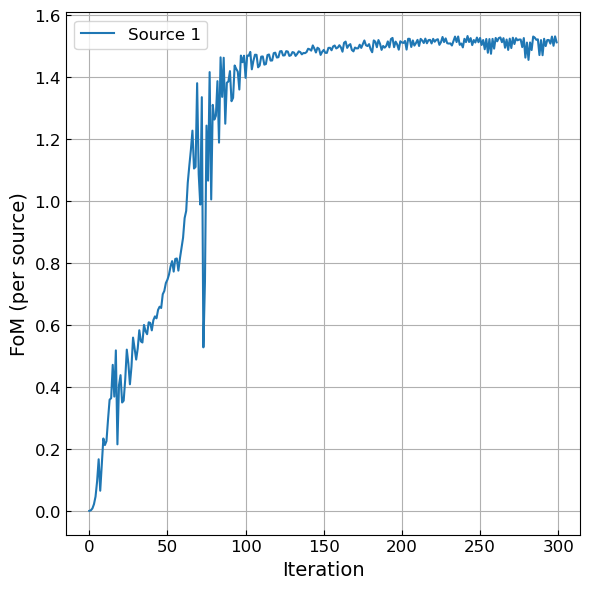

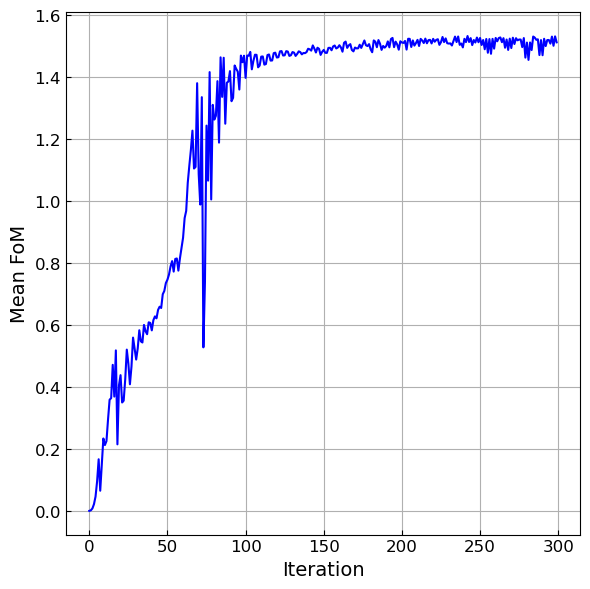

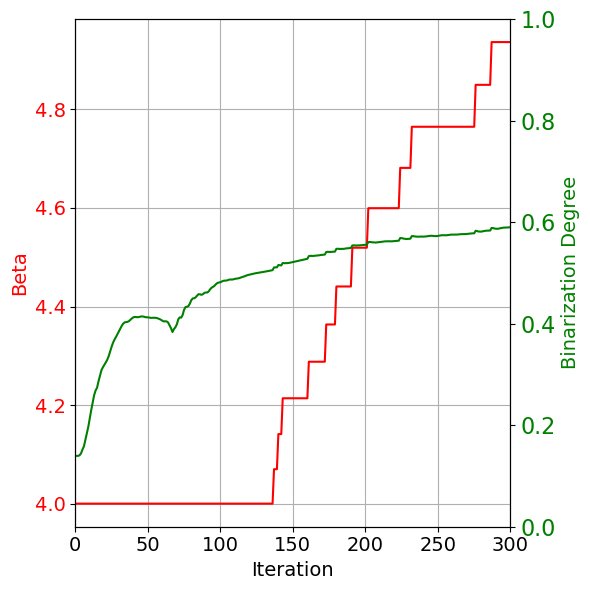

In [17]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom, 'b-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

TypeError: 'Axes' object is not subscriptable

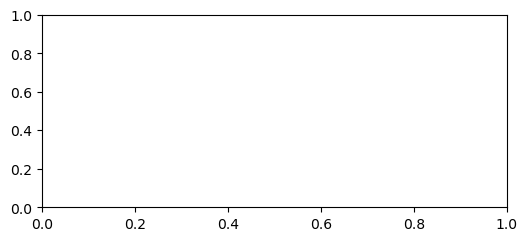

In [18]:
###################### [1-2] 각 소스별 FoM 개별 subplot ######################
num_sources = evaluation_array.shape[1]

fig, axs = plt.subplots(num_sources, 1, figsize=(6, 2.5*num_sources), sharex=True)

for i in range(num_sources):
    axs[i].plot(iterations, evaluation_array[:, i], label=f"Source {i+1}", color=f"C{i}")
    axs[i].set_ylabel("FoM", fontsize=12)
    axs[i].legend(fontsize=10)
    axs[i].grid(True)
    axs[i].tick_params(labelsize=10, direction='in')

axs[-1].set_xlabel("Iteration", fontsize=12)
fig.suptitle("FoM per Source (individual view)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# k = design_variables.weights
# np.savetxt("SingleDipole_sum.txt", k) 

In [29]:
design_load = np.loadtxt("SingleDipole_sum.txt")
for i in range(len(sources)):
    opt_list[i].update_design([design_load])

Plotting geometry for Source 1


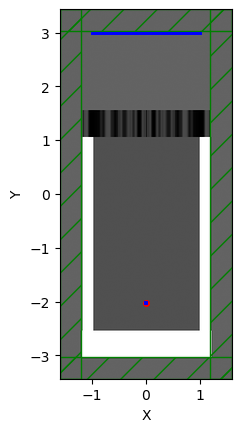

In [30]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(mn_size, 0)

input_flux_list = []
output_flux_list = []
dft_fields_list = []

for i in range(len(sources)):
    

    sim_i = opt_list[i].sim
    source_i = sources[i]

    input_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=source_i.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size),
                      weight=-1),
        mp.FluxRegion(center=source_i.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=source_i.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0),
                      weight=-1),
        mp.FluxRegion(center=source_i.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    output_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    dft_fields = sim_i.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    print(f"Plotting geometry for Source {i+1}")
    opt_list[i].plot2D()
    plt.show()


🔄 Iteration 시작 전 초기화: Source 1
▶️ Running Simulation for Source 1


/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


📊 Plotting 2D Ez for Source 1


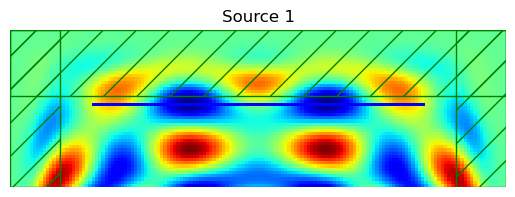

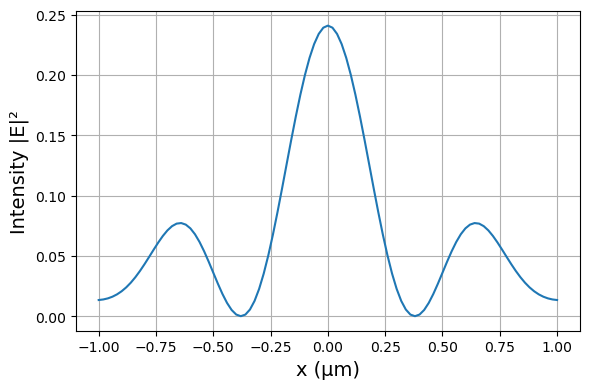


🔍 Source 1
  Input  flux : 0.242763
  Output flux : 0.147911
  EQE (%)     : 60.93 %

=== Summary EQE per source ===
Source 1: EQE = 60.93 %


In [31]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# verbosity off
mp.verbosity(0)

# parameters
offset    = 0.01
flux_size = 0.02
mn_size   = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size       = mp.Vector3(mn_size, 0)

# prepare storage
input_flux_list  = []
output_flux_list = []
dft_fields_list  = []
eqe_list         = []

# loop over sims & sources
for i, (sim, src) in enumerate(zip(sims, sources), start=1):
    print(f"\n🔄 Iteration 시작 전 초기화: Source {i}")
    sim.reset_meep()

    # add input flux monitor around the dipole
    input_flux = sim.add_flux(
        fcen, df, nfreq,
        mp.FluxRegion(center=src.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=src.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    # add output flux monitor at the planar monitor position
    output_flux = sim.add_flux(
        fcen, df, nfreq,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    # add DFT field monitor
    dft_fields = sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, df, nfreq,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    # run until fields decayed
    print(f"▶️ Running Simulation for Source {i}")
    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            10/(fmax-fmin), mp.Ez, src.center, 1e-5
        )
    )

    # spatial plot of Ez
    print(f"📊 Plotting 2D Ez for Source {i}")
    sim.plot2D(
        fields=mp.Ez,
        output_plane=mp.Volume(center=monitor_position_y,
                               size=mp.Vector3(3,1)),
        field_parameters={'post_process': lambda x: np.real(x),
                          'cmap': 'jet', 'alpha': 1,
                          'interpolation': 'none'},
        eps_parameters={'cmap':'magma','alpha':0.8}
    )
    plt.axis(False)
    plt.title(f"Source {i}", fontsize=12)
    plt.show()

    # 1D intensity profile from DFT
    E_line = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))
    x = np.linspace(-mn_size/2, mn_size/2, E_line.size)
    I = np.abs(E_line)**2

    plt.figure(figsize=(6,4))
    plt.plot(x, I, label=f"Source {i}")
    plt.xlabel('x (µm)', fontsize=14)
    plt.ylabel('Intensity |E|²', fontsize=14)
    # plt.title(f"Source {i} – Monitor size: {mn_size}µm", fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # compute EQE
    Pin  = mp.get_fluxes(input_flux)[0]
    Pout = mp.get_fluxes(output_flux)[0]
    eqe  = 100 * Pout/Pin
    eqe_list.append(eqe)

    print(f"\n🔍 Source {i}")
    print(f"  Input  flux : {Pin:.6f}")
    print(f"  Output flux : {Pout:.6f}")
    print(f"  EQE (%)     : {eqe:.2f} %")

# print summary
print("\n=== Summary EQE per source ===")
for i, val in enumerate(eqe_list, start=1):
    print(f"Source {i}: EQE = {val:.2f} %")


In [34]:
0.089686/0.242763*100

36.94385058678628

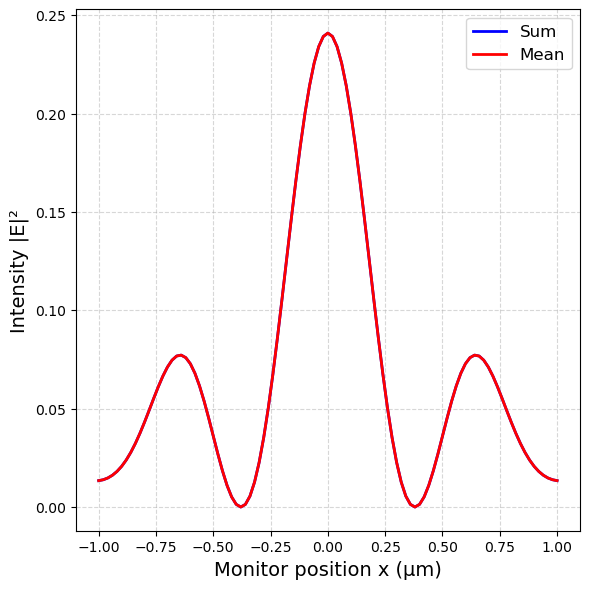

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# === 0) I_profiles 수집용 리스트 초기화 ===
I_profiles = []

# === 1) 각 sim에서 1D intensity 프로파일 계산 & 저장 ===
for sim, dft in zip(sims, dft_fields_list):
    # (이미 sim.run(...) 이 완료된 상태여야 합니다)
    E_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))  # 1D 배열 
    I = np.abs(E_line)**2                              # intensity
    I_profiles.append(I)

# === 2) x 좌표 벡터 생성 ===
N = I_profiles[0].size
x = np.linspace(-mn_size/2, mn_size/2, N)

# === 3) 합(sum) 및 평균(mean) 프로파일 계산 ===
I_stack = np.vstack(I_profiles)   # shape = (num_sources, N)
I_sum   = I_stack.sum(axis=0)     # 각 x 위치별 합
I_mean  = I_stack.mean(axis=0)    # 각 x 위치별 평균

# === 4) 한 그래프에 개별·합·평균 모두 그리기 ===
plt.figure(figsize=(6,6))

# (가) 개별 소스 프로파일: 연회색 얇은 선
for I in I_profiles:
    plt.plot(x, I, color='gray', alpha=0.3)

# (나) 합 프로파일: 검정 두꺼운 선
plt.plot(x, I_sum, 'b-', lw=2, label='Sum')

# (다) 평균 프로파일: 빨강 두꺼운 선
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')

plt.xlabel('Monitor position x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


적분 범위: ±0.380 µm → P_total(1차 링까지) = 0.089686


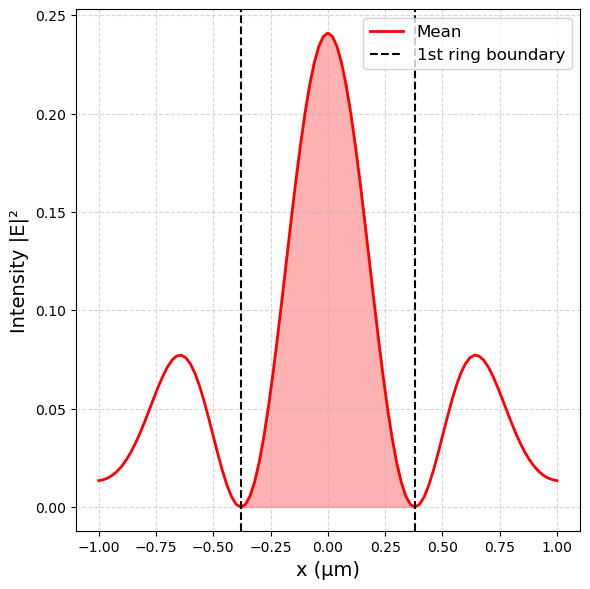

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 0) I_profiles & x, I_mean 계산 (생략 가능) ---
I_profiles = []
for sim, dft in zip(sims, dft_fields_list):
    Ez_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))
    I_profiles.append(np.abs(Ez_line)**2)

N       = I_profiles[0].size
x       = np.linspace(-mn_size/2, mn_size/2, N)
I_stack = np.vstack(I_profiles)
I_mean  = I_stack.mean(axis=0)   # sum 으로 되어 있던 부분 그대로

# --- 1) "진짜 중앙" 피크 찾기 ---
peaks, _ = find_peaks(I_mean)
if len(peaks)==0:
    center_idx = np.argmax(I_mean)
else:
    center_idx = peaks[np.argmin(np.abs(x[peaks]))]

# --- 2) 중앙 이후 첫 번째 · 두 번째 국소 최소점 검출 ---
minima_idx = []
for j in range(center_idx+1, N-1):
    if I_mean[j] < I_mean[j-1] and I_mean[j] < I_mean[j+1]:
        minima_idx.append(j)
        if len(minima_idx) >= 2:
            break

ring1_idx = minima_idx[0] if len(minima_idx)>0 else None
# ring2_idx = minima_idx[1] if len(minima_idx)>1 else None  # 더 이상 사용 안 함

x_ring1 = abs(x[ring1_idx]) if ring1_idx is not None else mn_size/2
# x_ring2 = abs(x[ring2_idx]) if ring2_idx is not None else mn_size/2

# --- 3) 적분 범위를 1차 링까지로 한정 ---
mask_total = (np.abs(x) <= x_ring1)   # <-- 2차 대신 1차 링까지
P_total    = np.trapz(I_mean[mask_total], x[mask_total])

# (원한다면 1차 링 내 세기도 별도 계산)
mask1 = mask_total
P1     = P_total
eff1   = 100.0  # P1 / P_total * 100 이므로 항상 100%

# --- 4) 결과 출력 ---
print(f"적분 범위: ±{x_ring1:.3f} µm → P_total(1차 링까지) = {P_total:.6f}")
# print(f"1차 링 내 세기 P1 = {P1:.6f}, 효율 = {eff1:.2f}%")

# --- 5) 시각화 ---
plt.figure(figsize=(6,6))
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')
plt.axvline(-x_ring1, ls='--', color='k', label='1st ring boundary')
plt.axvline(+x_ring1, ls='--', color='k')

plt.fill_between(x, I_mean, where=mask_total,
                 interpolate=True,
                 color='red', alpha=0.3)

plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


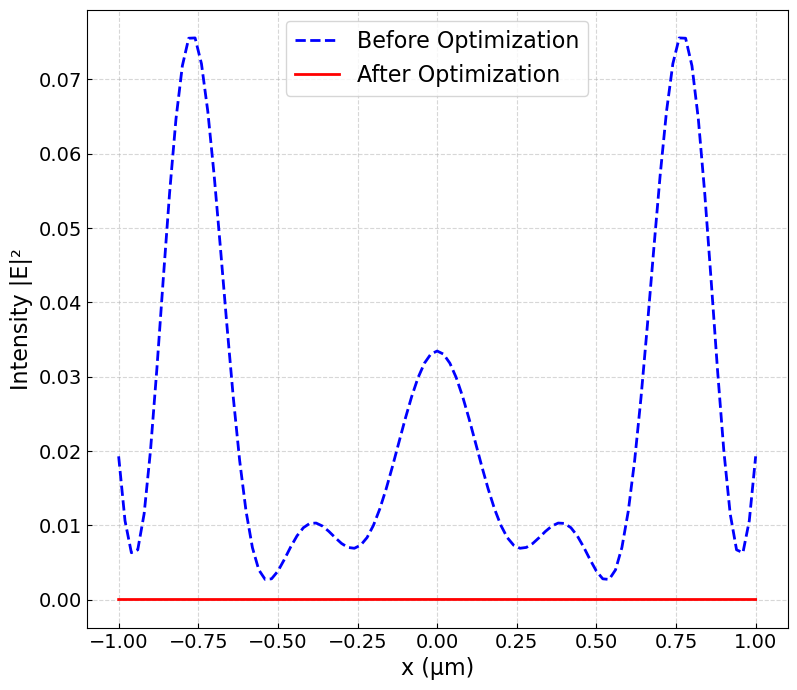

Average efficiency (Current/Saved mean): 0.01%


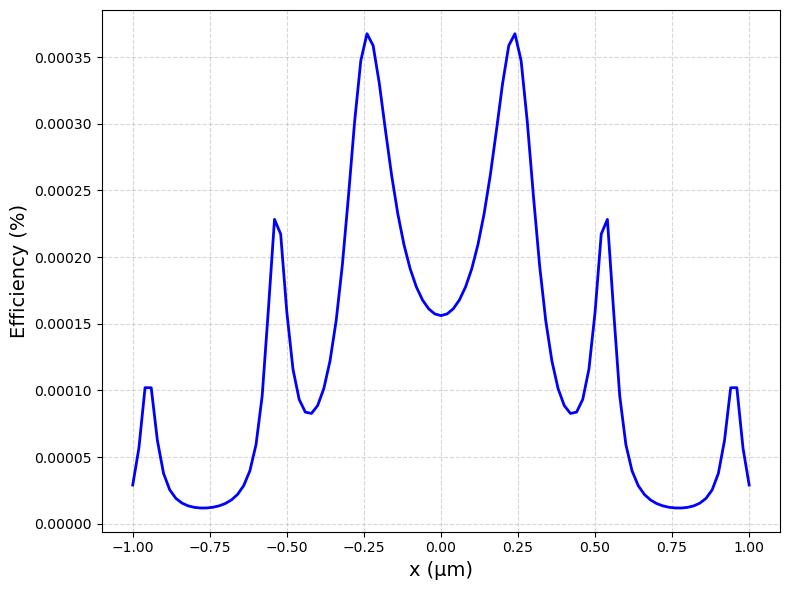

In [122]:
import numpy as np
import matplotlib.pyplot as plt

file_path = '/home/min/EIDL/Tool/Meep/LGD/LGD setup/Mode decomposition/Kyungmin/2025/07/22/Postprocess/combined_intensity.txt'

data = np.loadtxt(file_path)
x_loaded, I_sum_loaded, I_mean_loaded = data.T
plt.figure(figsize=(8,7))

plt.plot(x_loaded, I_mean_loaded, 'b--', lw=2, label='Before Optimization')

plt.plot(x, I_mean, 'r-', lw=2, label='After Optimization')

plt.xlabel('x (µm)', fontsize=16)
plt.ylabel('Intensity |E|²', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tick_params(direction = 'in')
plt.show()

eff_line = (I_mean / I_mean_loaded) 

avg_eff = np.mean(eff_line)* 100
print(f"Average efficiency (Current/Saved mean): {avg_eff:.2f}%")

plt.figure(figsize=(8,6))
plt.plot(x_loaded, eff_line, 'b-', lw=2)
plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Efficiency (%)', fontsize=14)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

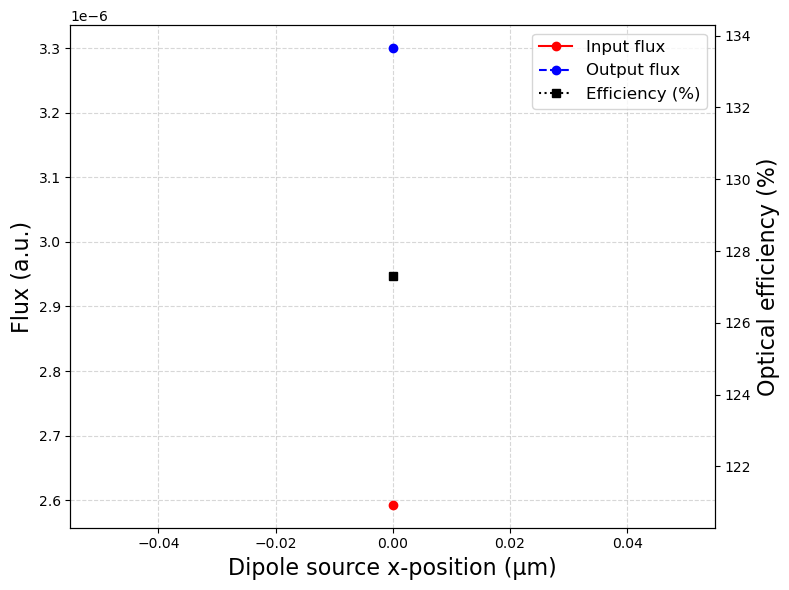

In [123]:
positions      = [src.center.x for src in sources]
input_values   = [mp.get_fluxes(f)[0] for f in input_flux_list]
output_values  = [mp.get_fluxes(f)[0] for f in output_flux_list]
percent_values = [100 * outv / inv if inv != 0 else 0
                  for inv, outv in zip(input_values, output_values)]

fig, ax1 = plt.subplots(figsize=(8,6))

# 왼쪽 축에 입력/출력 flux
ax1.plot(positions, input_values,  'ro-', label='Input flux')
ax1.plot(positions, output_values, 'bo--', label='Output flux')
ax1.set_xlabel('Dipole source x-position (µm)', fontsize=16)
ax1.set_ylabel('Flux (a.u.)',              fontsize=16, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='both', ls='--', alpha=0.5)

# 오른쪽 축에 효율
ax2 = ax1.twinx()
ax2.plot(positions, percent_values, 'ks:', label='Efficiency (%)')
ax2.set_ylabel('Optical efficiency (%)', fontsize=16, color='k')
ax2.tick_params(axis='y', labelcolor='k')

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)

plt.tight_layout()
plt.show()


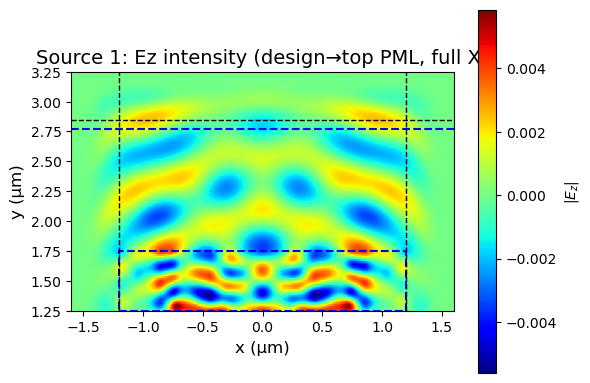

In [65]:
# 1) Y 범위: 디자인 영역 바닥→상단 PML 끝 (기존과 동일)
y_design_bot = center_y_design - design_region_height/2
y_start     = y_design_bot
y_end       = Sy/2

# 2) X 범위: 셀 전체 폭 (PML 포함)
x_start = -Sx/2
x_end   =  Sx/2

# 3) 해상도 벡터 재계산
nx   = int(resolution * Sx) + 1
x_res = np.linspace(x_start, x_end, nx)

ny   = int(resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

# 4) Volume 정의: X=Sx, Y=y_end–y_start
vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=mp.Vector3(Sx, y_end - y_start, 0)
)

# 5) 플롯 루프
# 5) 플롯 루프
for i in range(num_sources):
    Ez_slice = opt_list[i].sim.get_array(mp.Ez, vol).T
    I = np.real(Ez_slice)
    
    # I_max = np.max(np.real(Ez_slice))
    # I = np.real(Ez_slice)/I_max

    plt.figure(figsize=(6,4))
    plt.imshow(
        I,
        origin='lower',
        extent=[x_start, x_end, y_start, y_end],
        aspect='equal',
        cmap='jet'
    )
    plt.colorbar(label=r'$|E_z|$')
    plt.title(f"Source {i+1}: Ez intensity (design→top PML, full X)", fontsize=14)
    plt.xlabel('x (µm)', fontsize=12)
    plt.ylabel('y (µm)', fontsize=12)

    # — 디자인 영역 표시 —
    x0, x1 = -design_region_width/2, design_region_width/2
    y0 = y_design_bot
    y1 = y_design_bot + design_region_height
    plt.plot(
        [x0, x1, x1, x0, x0],
        [y0, y0, y1, y1, y0],
        'b--', lw=1.5, label='Design region'
    )

    # — 모니터 평면 표시 —
    plt.axhline(center_y_monitor_position, color='blue',
                ls='--', lw=1.5, label='Monitor plane')

    # — PML 경계 표시 (점선) —
    # 수평 PML 경계
    # plt.axhline(y_start + tpml,          color='yellow', ls='--', lw=1, label='Bottom PML end')
    plt.axhline(y_end   - tpml,          color='k', ls='--', lw=1, label='Top PML start')
    # 수직 PML 경계
    plt.axvline(x_start + tpml,          color='k', ls='--', lw=1, label='Left PML end')
    plt.axvline(x_end   - tpml,          color='k', ls='--', lw=1, label='Right PML start')

    # — 축범위 고정 —
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)

    # plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()



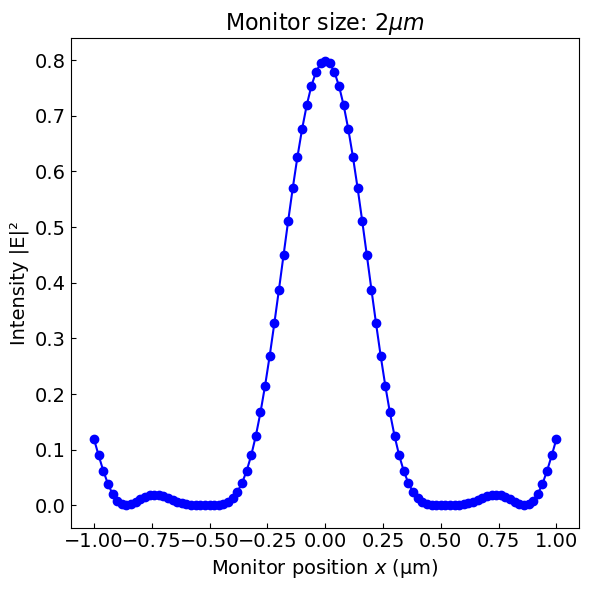

In [31]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt_list[2].sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

#### 소스 위치나 모니터 위치, 구조물 등등)

IndexError: list index out of range

In [77]:
input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
print("Input되고 있는 flux : ", input)

NameError: name 'input_flux_list' is not defined

In [ ]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'

In [26]:
import numpy as np

# 1) 강도 계산
I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
center_idx = np.argmax(I)

# 2) 첫 번째 링 경계: 미분으로 valley 찾기
dI = np.diff(I)
valleys = np.where((dI[:-1] < 0) & (dI[1:] > 0))[0] + 1
valleys = valleys[valleys > center_idx]
if valleys.size == 0:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")
idx_valley = valleys[0]
x_limit = abs(x[idx_valley])

# 3) 적분 구간 설정
mask = (x >= -x_limit) & (x <= x_limit)
dx = x[1] - x[0]
flux_slice = np.sum(I[mask]) * dx

# 4) Flux 모니터 값
input_flux  = np.array(mp.get_fluxes(input_flux))[0]
output_flux = np.array(mp.get_fluxes(out_flux))[0]

# 5) Optical EQE 계산: 출력 flux 비율을 사용
optical_eqe = output_flux / input_flux * 100

print(f"±{x_limit:.3f} µm 구간 intensity 적분: {flux_slice:.4f}")
print(f"모니터 기반 Optical EQE: {optical_eqe:.2f}%")


±0.320 µm 구간 intensity 적분: 1.0391
모니터 기반 Optical EQE: 75.64%


In [287]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'